In [1]:
import tensorflow as tf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 

# para construir a arvore
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# para separar os dados e validar resultados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# para construir e plotar a matriz de confusao
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")

# Pré-processamento dos dados






Lendo a base de dados e dispensando as colunas desnecessárias.

In [27]:
data = pd.read_csv('data.csv',sep=',', usecols = lambda column:column not in ['Unnamed: 0','cod_curso','cod_matricula','cod_ciclo_matricula'])
data.head()

,nome_curso,carga_horaria,eixo_tec,fator_esforco,tipo_curso,turno,situacao,inicio_curso,final_esperado,renda,sexo,faixa_etaria,cor
0,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,E,22/05/2017,28/04/2022,"1,0<RFP<=1,5",M,15-19,branca
1,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,E,22/05/2017,28/04/2022,"0<RFP<=0,5",M,25-29,parda
2,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,E,22/05/2017,28/04/2022,"0,5<RFP<=1",M,20-24,branca
3,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,E,22/05/2017,28/04/2022,"1,0<RFP<=1,5",M,20-24,branca
4,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,E,07/04/2014,31/12/2017,"1,0<RFP<=1,5",M,30-34,branca


Separando os dados. 


*   X = features de cada aluno na base
*   y = variável preditora (coluna **situacao**)



In [28]:
X = data.loc[:,['nome_curso',
 'carga_horaria',
 'eixo_tec',
 'fator_esforco',
 'tipo_curso',
 'turno',
 'inicio_curso',
 'final_esperado',
 'renda',
 'sexo',
 'faixa_etaria',
 'cor']]
X.head(3)

,nome_curso,carga_horaria,eixo_tec,fator_esforco,tipo_curso,turno,inicio_curso,final_esperado,renda,sexo,faixa_etaria,cor
0,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,22/05/2017,28/04/2022,"1,0<RFP<=1,5",M,15-19,branca
1,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,22/05/2017,28/04/2022,"0<RFP<=0,5",M,25-29,parda
2,engenharia civil,3800,infraestrutura,1.14,bacharelado,integral,22/05/2017,28/04/2022,"0,5<RFP<=1",M,20-24,branca


In [29]:
y = data.loc[:,['situacao']]
y.head(3)

,situacao
0,E
1,E
2,E


 <h2>
    Variáveis dummy/fictícias.
  </h2>
Para trabalhar com os algortimos as variáveis categóricas serão transformadas em valores 0 ou 1. O número de variáveis fictícias criadas é de k-1, onde k são os valores possíveis que uma variável categórica pode assumir.

Tendo na coluna **tipo_curso** os valores de:


*   bacharelado
*   tecnologia
*   licenciatura

então tem-se k = 3. E então duas variáveis fictícias são criadas para a coluna tipo_curso. Isso serve para evitar o problema de multicolinearidade que faz com que nossas variáveis fiquem altamente correlacionadas.

Para realizar esse processo usaremos o método OneHotEncoder do sklearn com o parâmetro `drop = first` para criar k-1 variáveis em cada coluna especificada.


In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [31]:
enc = OneHotEncoder(handle_unknown='ignore',drop='first')

In [32]:
# guardando as varáveis categóricas
X_cat = X[['nome_curso','eixo_tec','tipo_curso','turno','inicio_curso','final_esperado','renda','sexo','faixa_etaria','cor']]
X_cat

,nome_curso,eixo_tec,tipo_curso,turno,inicio_curso,final_esperado,renda,sexo,faixa_etaria,cor
0,engenharia civil,infraestrutura,bacharelado,integral,22/05/2017,28/04/2022,"1,0<RFP<=1,5",M,15-19,branca
1,engenharia civil,infraestrutura,bacharelado,integral,22/05/2017,28/04/2022,"0<RFP<=0,5",M,25-29,parda
2,engenharia civil,infraestrutura,bacharelado,integral,22/05/2017,28/04/2022,"0,5<RFP<=1",M,20-24,branca
3,engenharia civil,infraestrutura,bacharelado,integral,22/05/2017,28/04/2022,"1,0<RFP<=1,5",M,20-24,branca
4,engenharia civil,infraestrutura,bacharelado,integral,07/04/2014,31/12/2017,"1,0<RFP<=1,5",M,30-34,branca
...,...,...,...,...,...,...,...,...,...,...
5504,engenharia de computacao,informacao e comunicacao,bacharelado,integral,25/01/2021,31/12/2025,"1,5<RFP<=2,5",M,15-19,parda
5505,engenharia de computacao,informacao e comunicacao,bacharelado,integral,21/06/2021,31/12/2025,"1,0<RFP<=1,5",M,25-29,branca
5506,engenharia de computacao,informacao e comunicacao,bacharelado,integral,21/06/2021,31/12/2025,"0,5<RFP<=1",M,15-19,parda
5507,engenharia de computacao,informacao e comunicacao,bacharelado,integral,21/06/2021,31/12/2025,"1,0<RFP<=1,5",M,15-19,branca


In [33]:
X_encoded = enc.fit_transform(X_cat).toarray() # codificando as variáveis categóricas

In [34]:
enc.categories_[:2]

[array(['administracao', 'agroecologia', 'alimentos',
        'analise e desenvolvimento de sistemas', 'automacao industrial',
        'ciencias biologicas', 'construcao de edificios',
        'design de interiores', 'design grafico', 'educacao fisica',
        'engenharia civil', 'engenharia de computacao',
        'engenharia de controle e automacao', 'engenharia eletronica',
        'engenharia mecanica', 'fisica', 'geoprocessamento',
        'gestao ambiental', 'gestao comercial', 'matematica',
        'medicina veterinaria', 'negocios imobiliarios', 'quimica',
        'redes de computadores', 'seguranca no trabalho',
        'sistemas de telecomunicacoes', 'sistemas para internet',
        'telematica'], dtype=object),
 array(['ambiente e saude', 'controle e processos industriais',
        'desenvolvimento educacional e social', 'gestao e negocios',
        'informacao e comunicacao', 'infraestrutura',
        'producao alimenticia', 'producao cultural e design',
        'recursos

In [35]:
X_encoded = pd.DataFrame(X_encoded) # transformando em DataFrame
X_encoded.columns = enc.get_feature_names_out() # renomeando as colunas

In [36]:
X_encoded.head()

,nome_curso_agroecologia,nome_curso_alimentos,nome_curso_analise e desenvolvimento de sistemas,nome_curso_automacao industrial,nome_curso_ciencias biologicas,nome_curso_construcao de edificios,nome_curso_design de interiores,nome_curso_design grafico,nome_curso_educacao fisica,nome_curso_engenharia civil,...,faixa_etaria_35-39,faixa_etaria_40-44,faixa_etaria_45-49,faixa_etaria_50-54,faixa_etaria_55-59,faixa_etaria_Maior de 60 anos,cor_branca,cor_indigena,cor_parda,cor_preta
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
X_numerical = data[['carga_horaria','fator_esforco']] # guardando as variáveis numéricas
X_numerical.head(3)

,carga_horaria,fator_esforco
0,3800,1.14
1,3800,1.14
2,3800,1.14


In [38]:
X_all = pd.concat([X_encoded, X_numerical],axis=1) # concatenando os dataframes
X_all.head()

,nome_curso_agroecologia,nome_curso_alimentos,nome_curso_analise e desenvolvimento de sistemas,nome_curso_automacao industrial,nome_curso_ciencias biologicas,nome_curso_construcao de edificios,nome_curso_design de interiores,nome_curso_design grafico,nome_curso_educacao fisica,nome_curso_engenharia civil,...,faixa_etaria_45-49,faixa_etaria_50-54,faixa_etaria_55-59,faixa_etaria_Maior de 60 anos,cor_branca,cor_indigena,cor_parda,cor_preta,carga_horaria,fator_esforco
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3800,1.14
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3800,1.14
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3800,1.14
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3800,1.14
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3800,1.14


<h1>Lidando com as diferenças nos valores</h1>

Se observamos os valores a maioria deles está como 0 ou 1. Porém existem duas colunas numéricas na base que são **carga_horaria** e **fator_esforco** que diferem muito disso.

In [39]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler((0,1))
X_scaled = sc.fit_transform(X_all)

In [26]:
# como vira um array, estou convertendo de volta para DataFrame para poder usar o describe
df_scaled = pd.DataFrame(X_scaled)

# agora todos os dados estão dentro do mesmo intervalo 0 e 1
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,528,529,530,531,532,533,534,535,536,537
count,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,...,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000
mean,0.053186,0.010891,0.049918,0.054819,0.012343,0.083681,0.033944,0.027773,0.009984,0.041568,...,0.024142,0.015248,0.007261,0.002904,0.366491,0.002360,0.529316,0.086767,0.333987,0.378420
std,0.224424,0.103801,0.217796,0.227648,0.110423,0.276934,0.181103,0.164336,0.099427,0.199619,...,0.153505,0.122548,0.084908,0.053818,0.481890,0.048525,0.499185,0.281519,0.230515,0.296871
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207413,0.107143
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.246724,0.285714
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.484463,0.714286
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h3>Codificando a variável dependente <b>situacao</b></h3>
Assim como os valores das features categóricas em X foram transformados em 0 e 1 o mesmo será feito com y. Como é apenas uma única coluna usa-se o LabelEncoder.

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([1, 1, 1, ..., 1, 1, 1])

A varíavel vira um array numpy após esse processo. Podemos converter de volta para DataFrame para observar melhor os valores armazenando em um nova variável. 

In [163]:
df = pd.DataFrame(y_encoded, columns = ['situacao'])

df.head(6)
# concluise que:
# E = 1
# C = 0

,situacao
0,1
1,1
2,1
3,1
4,1
5,0


In [42]:
# observando os tipos das variáveis
print(type(X_scaled))
print(type(y_encoded))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<h1>Separando os dados em conjunto de treino e teste</h1>
Será utilizado 20% dos dados para teste e 80% para treino.

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_encoded,test_size=0.2,random_state=42)

In [44]:
print(f"Para X_train tem-se 4407 linhas e 538 colunas:{X_train.shape}")
print(f"Para X_test tem-se 1102 linhas e 538 colunas:{X_test.shape}")
print(f"Para y_train tem-se 4407 linhas com os valores de classe referentes a cada amostra em X_train:{y_train.shape}")
print(f"Para y_test tem-se 1102 linhas com os valores de classe referentes a cada amostra em X_test:{y_test.shape}")

Para X_train tem-se 4407 linhas e 538 colunas:(4407, 538)
Para X_test tem-se 1102 linhas e 538 colunas:(1102, 538)
Para y_train tem-se 4407 linhas com os valores de classe referentes a cada amostra em X_train:(4407,)
Para y_test tem-se 1102 linhas com os valores de classe referentes a cada amostra em X_test:(1102,)


In [45]:
print(X_train)

[[0.         0.         0.         ... 0.         0.24672407 0.71428571]
 [0.         0.         0.         ... 0.         0.24672407 0.71428571]
 [1.         0.         0.         ... 0.         0.2006739  0.71428571]
 ...
 [0.         0.         0.         ... 0.         0.22126544 0.82142857]
 [0.         0.         0.         ... 0.         0.22126544 0.82142857]
 [1.         0.         0.         ... 0.         0.2006739  0.71428571]]


In [46]:
print(X_test)

[[0.         0.         0.         ... 0.         0.24672407 0.71428571]
 [0.         0.         1.         ... 0.         0.20741295 0.89285714]
 [0.         0.         0.         ... 0.         0.22014227 0.10714286]
 ...
 [0.         1.         0.         ... 0.         0.35904156 0.71428571]
 [0.         0.         0.         ... 0.         0.24672407 0.71428571]
 [0.         0.         0.         ... 0.         0.25046799 0.14285714]]


In [47]:
display(y_train)
display(y_test)

array([0, 1, 1, ..., 0, 1, 0])

array([1, 1, 1, ..., 1, 0, 0])

# Aplicação dos algoritmos

## KNN classifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import accuracy_score,  precision_score, f1_score, recall_score,classification_report

In [49]:
accuracies = [] # lista para guardar as acurácias obtidas em cada valor de k
for i in range (1,21):  # testando para 20 valores de k
    knn = KNeighborsClassifier(n_neighbors=i, weights = 'uniform', metric='euclidean')
    knn.fit(X_train,y_train)
    predict_i = knn.predict(X_test)

    accuracy = accuracy_score(y_test,predict_i)
    accuracy = round(accuracy*100)

    accuracies.append(accuracy)

#### Achando melhor K

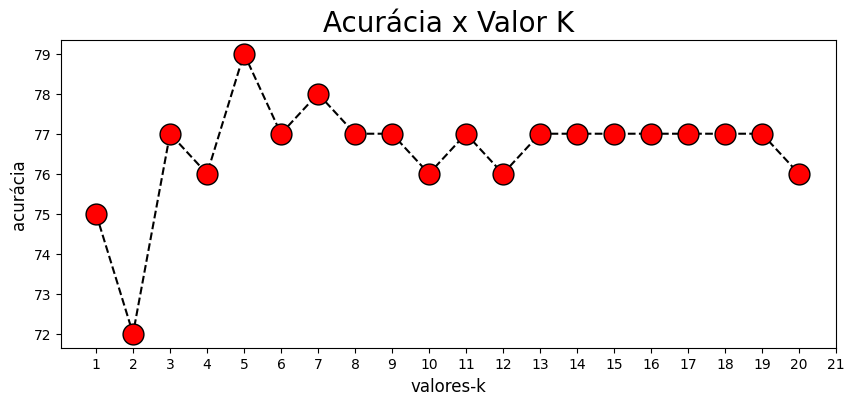

In [50]:
# plotando os resultados
plt.figure(figsize=(10,4))
plt.plot(range(1,21),accuracies,marker="o",markerfacecolor="red", linestyle="dashed", color="black",markersize=15)
plt.title("Acurácia x Valor K",fontsize=20)
plt.xlabel("valores-k",fontsize=12)
plt.ylabel("acurácia",fontsize=12)
plt.xticks(range(1,22))
plt.show()

O melhor valor de k foi 5

In [51]:
knn = KNeighborsClassifier(n_neighbors = 5 , weights = 'uniform', metric='euclidean')
knn.fit(X_train, y_train)    

KNeighborsClassifier(metric='euclidean')

In [52]:
KNNpredicted = knn.predict(X_test)

In [53]:
# criando matriz de confusão
conf_matrix = confusion_matrix(y_test,KNNpredicted)

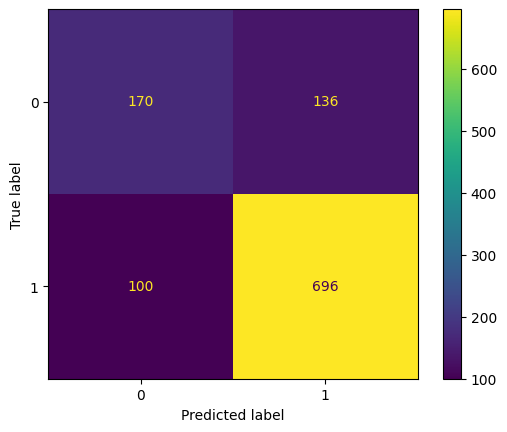

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = knn.classes_)
disp.plot()

#### Analisando resultados do KNN

In [55]:
conf_matrix

array([[170, 136],
       [100, 696]])

In [56]:
print(f'Previu {conf_matrix[1,1]} evadidos (1) corretamente')
print(f'Previu {conf_matrix[0,0]} concluintes (0) corretamente')
print(f'Previu incorretamente {conf_matrix[0,1]} concluintes quando eram evadidos')
print(f'Previu incorretamente {conf_matrix[1,0]} evadidos quando eram concluintes')

Previu 696 evadidos (1) corretamente
Previu 170 concluintes (0) corretamente
Previu incorretamente 136 concluintes quando eram evadidos
Previu incorretamente 100 evadidos quando eram concluintes


In [57]:
print('Precisão: %.2f' % precision_score(y_test, KNNpredicted))
print('Acurácia: %.2f' % accuracy_score(y_test, KNNpredicted))
print('F1 Score: %.2f' % f1_score(y_test, KNNpredicted))
print('Recall Score: %.2f' % recall_score(y_test, KNNpredicted))
print(classification_report(y_test,KNNpredicted))

Precisão: 0.84
Acurácia: 0.79
F1 Score: 0.86
Recall Score: 0.87
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       306
           1       0.84      0.87      0.86       796

    accuracy                           0.79      1102
   macro avg       0.73      0.71      0.72      1102
weighted avg       0.78      0.79      0.78      1102



## Decision Tree

In [58]:
from sklearn.metrics import roc_curve, auc

Criando uma função para calcular os diferentes índices AUC para os modelos treinados. Essa função será utilizada para encontrar o melhor parâmetro para os modelos de regressão logística e árvores de decisão. Para árovores de decisão o parâmetro a ser ajustado será o **max_depth** e para regressão logística o parâmetro **C**.


In [59]:
def cal_roc_auc_for_train_test(model_name, num_params):
  train_results = []
  test_results = []
  if model_name == 'decision tree':
      for max_depth in num_params:
        dt = DecisionTreeClassifier(max_depth=max_depth)
        dt.fit(X_train, y_train)
        # prevendo para os dados de treino
        x_train_pred = dt.predict(X_train)

        # temos que pegar os thresholds, proporcao de verdadeiros positivos e falsos positivos
        # obtidos pela curva roc.
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, x_train_pred)
        # depois disso podemos calcular o auc
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # adicionando os resultados da curva roc/auc em train_results
        train_results.append(roc_auc)

        # prevendo para os dados de teste
        y_test_pred = dt.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        # adicionando os resultados da curva roc/auc em test_results
        test_results.append(roc_auc)
      plot_roc_auc_for_train_test(num_params,'max_depth',train_results,test_results)
  if model_name == 'logistic regression':
      for c in num_params:
        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
   
        x_train_pred = lr.predict(X_train)

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, x_train_pred)

        roc_auc = auc(false_positive_rate, true_positive_rate)

        train_results.append(roc_auc)

        y_test_pred = lr.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)

        test_results.append(roc_auc)
      plot_roc_auc_for_train_test(num_params,'c_value',train_results,test_results)


def plot_roc_auc_for_train_test(num_params,x_label_name,train_results,test_results):
  plt.plot(num_params, train_results, 'green', label='Train AUC', marker='o'
            ,markersize=5,markerfacecolor="green")
  plt.plot(num_params, test_results, 'r', label='Test AUC',marker='o'
            ,markersize=5,markerfacecolor="red")
  plt.legend()
  plt.ylabel('AUC score')
  plt.xlabel(x_label_name)
  plt.show()


#### Achando o melhor max_depth

In [60]:
max_depths = np.arange(1, 26)
max_depths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

Quanto maior for o valor de AUC, melhor o nosso modelo está. Através do AUC é possível mensurar o nível de separabilidade do modelo, isto é, o quão bom ele está em prever classes 0 como 0 e classes 1 como 1. Para o nosso caso, quanto maior o AUC, maior a capacidade do modelo em distinguir alunos evadidos (1) de concluintes (0).

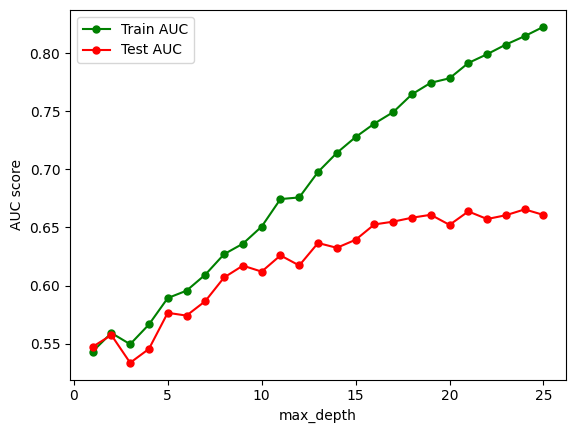

In [61]:
cal_roc_auc_for_train_test('decision tree', max_depths)

Parar no 21 parece uma boa ideia, já que depois disso não parece haver tanto ganho olhando para os resultados com os dados de teste.

In [62]:
decision_tree = DecisionTreeClassifier(max_depth = 21, random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=21, random_state=42)

#### Analisando os resultados do Decision Tree

In [63]:
y_pred = decision_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)

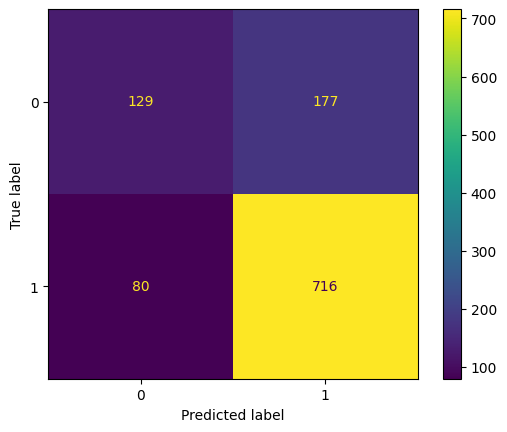

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = decision_tree.classes_)
disp.plot()

In [65]:
print(f'Previu {conf_matrix[1,1]} evadidos (1) corretamente')
print(f'Previu {conf_matrix[0,0]} concluintes (0) corretamente')
print(f'Previu incorretamente {conf_matrix[0,1]} concluintes quando eram evadidos')
print(f'Previu incorretamente {conf_matrix[1,0]} evadidos quando eram concluintes')

Previu 716 evadidos (1) corretamente
Previu 129 concluintes (0) corretamente
Previu incorretamente 177 concluintes quando eram evadidos
Previu incorretamente 80 evadidos quando eram concluintes


In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.42      0.50       306
           1       0.80      0.90      0.85       796

    accuracy                           0.77      1102
   macro avg       0.71      0.66      0.67      1102
weighted avg       0.75      0.77      0.75      1102



#### Visualizando a importância das features para Decision Tree

<Axes: >

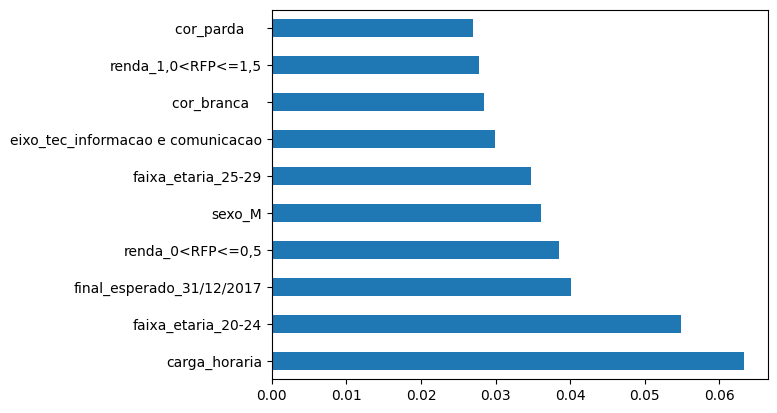

In [69]:
feat_importances = pd.Series(decision_tree.feature_importances_, index=X_all.columns)
feat_importances.nlargest(10).plot(kind='barh')

As features mais importantes foram relacionadas a carga horária, cor parda e branca, eixo tecnológico, faixa etária de 20 até 29 e renda de 0,5 a 1.5.

## Logistic Regression

#### Achando melhor C

In [70]:
c_params = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000] # valores para C

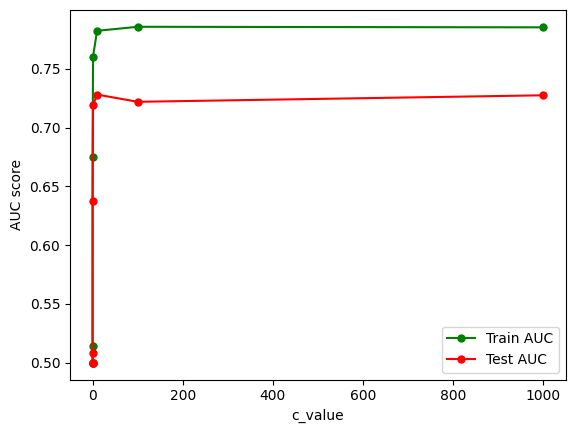

In [71]:
cal_roc_auc_for_train_test('logistic regression', c_params)

O AUC mais alto para os dados de teste está no quinto ponto que equivale a C = 1.0

#### Treinando a analisando resultados do LogisticRegression

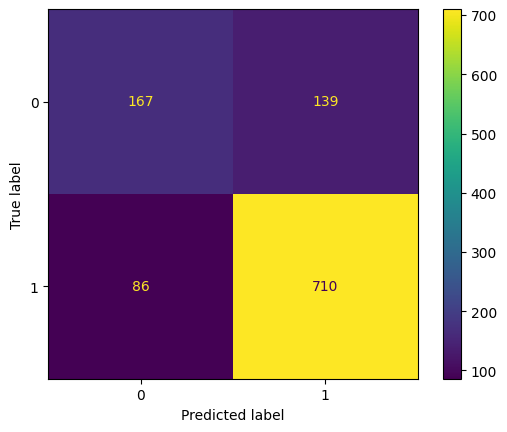

In [72]:
logistic_regression = LogisticRegression(C=1.0, random_state=42)
logistic_regression.fit(X_train,y_train)
y_pred = logistic_regression.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = logistic_regression.classes_)
disp.plot()

In [73]:
print(f'Previu {conf_matrix[1,1]} evadidos (1) corretamente')
print(f'Previu {conf_matrix[0,0]} concluintes (0) corretamente')
print(f'Previu incorretamente {conf_matrix[0,1]} concluintes quando eram evadidos')
print(f'Previu incorretamente {conf_matrix[1,0]} evadidos quando eram concluintes')

Previu 710 evadidos (1) corretamente
Previu 167 concluintes (0) corretamente
Previu incorretamente 139 concluintes quando eram evadidos
Previu incorretamente 86 evadidos quando eram concluintes


In [74]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60       306
           1       0.84      0.89      0.86       796

    accuracy                           0.80      1102
   macro avg       0.75      0.72      0.73      1102
weighted avg       0.79      0.80      0.79      1102



## **Comparando os modelos pela curva ROC** 

In [75]:
def compare_models_by_roc_curve(model,label_name):
  # calculando roc
  y_pred_probability = model.predict_proba(X_test)[::,1]
  # calculando também o auc
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)
  auc = metrics.roc_auc_score(y_test, y_pred_probability)
  plt.plot(fpr,tpr,label=label_name+",auc="+str(auc))

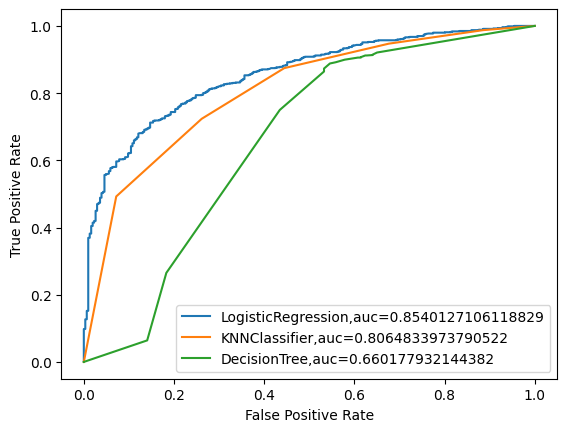

In [76]:
compare_models_by_roc_curve(logistic_regression,"LogisticRegression")
compare_models_by_roc_curve(knn,"KNNClassifier")
compare_models_by_roc_curve(decision_tree,"DecisionTree")
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.show()

A Regressão Logística foi melhor que o KNN e o Árvores de Decisão.

## Support Vector Machine

In [77]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Seŕa utilizado o kernel rbf. Para otimizar modelo vamos achar o melhor valor para os parâmetros **C** e **gamma**.

Como temos dois parâmetros para otimizar, usaremos o GridSearch. 

#### Encontrando o melhor C e o melhor gamma

In [78]:
param_grid = [
    {'C':[0.5,1,10,100], # valores para C
    'gamma':['scale',1,0.1,0.01,0.001,0.0001], # valores para gamma
    'kernel':['rbf']},
]

optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring='accuracy',
    verbose=0 
)

# agora executamos a validação cruzada nos valores
# dos parametros usando os dados de treinamento e,
# em seguida, imprimimos os melhores parametros.
optimal_params.fit(X_train,y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


#### Treinando e analisando os resultados do SVM

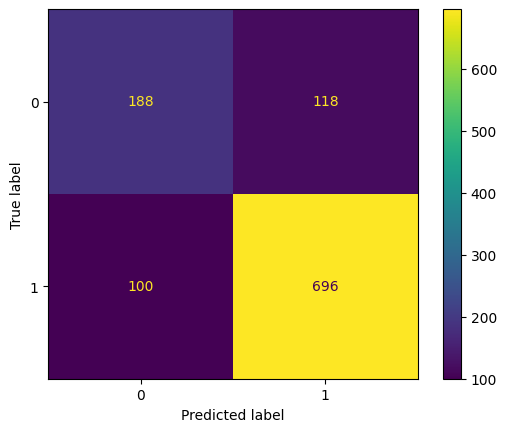

In [79]:
clf_svm = SVC(random_state=42,C=100,
    kernel='rbf',
    gamma=0.01,probability=True)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = clf_svm.classes_)
disp.plot()

In [80]:
print(f'Previu {conf_matrix[1,1]} evadidos (1) corretamente')
print(f'Previu {conf_matrix[0,0]} concluintes (0) corretamente')
print(f'Previu incorretamente {conf_matrix[0,1]} concluintes quando eram evadidos')
print(f'Previu incorretamente {conf_matrix[1,0]} evadidos quando eram concluintes')

Previu 696 evadidos (1) corretamente
Previu 188 concluintes (0) corretamente
Previu incorretamente 118 concluintes quando eram evadidos
Previu incorretamente 100 evadidos quando eram concluintes


In [81]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       306
           1       0.86      0.87      0.86       796

    accuracy                           0.80      1102
   macro avg       0.75      0.74      0.75      1102
weighted avg       0.80      0.80      0.80      1102



# Neural Network

In [83]:
!pip3 install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=5dc899003797195b0c28ebc285cf407e2e49272ee151eeda76bc555f0d7e11c6
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


#### Iniciando e compilando a rede

In [84]:
from ann_visualizer.visualize import ann_viz
import graphviz

In [94]:
rna = tf.keras.models.Sequential()
rna.add(tf.keras.layers.Dense(units=3,activation='relu'))
rna.add(tf.keras.layers.Dense(units=3,activation='relu'))
rna.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
rna.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#### Treinando a Rede

In [95]:
rna.fit(X_train,y_train,batch_size=20,epochs=10,verbose=0)

#### Visualizando a estrutura da rede

In [87]:
ann_viz(rna, view=True, title='Artifical Neural Network')

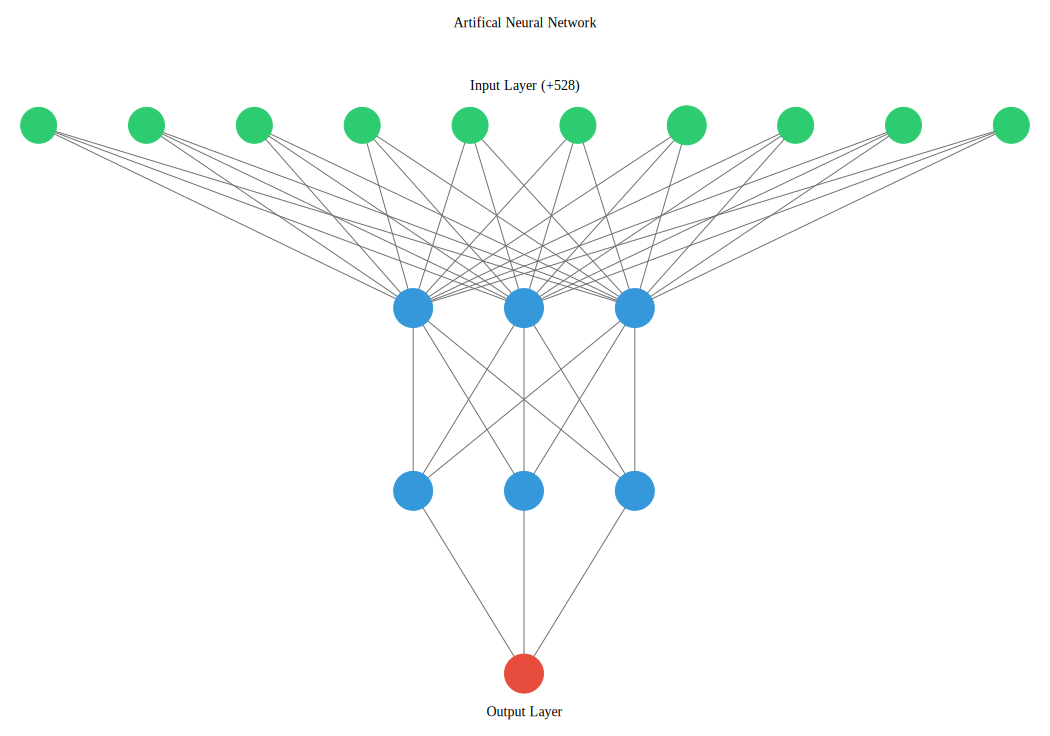

In [88]:
graph_file = graphviz.Source.from_file('network.gv')
graph_file

#### Analisando os resultados da rede neural

In [96]:
y_pred = rna.predict(X_test)
# pegando os valores preditos acima de 50%
y_pred = (y_pred>0.5)
print(y_pred)

35/35 [==============================] - 0s 1ms/step
[[ True]
 [ True]
 [ True]
 ...
 [False]
 [ True]
 [False]]


In [97]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[194 112]
 [124 672]]


In [98]:
print('Precisão: %.2f' % precision_score(y_test, y_pred))
print('F1 Score: %.2f' % f1_score(y_test, y_pred))
print('Recall Score: %.2f' % recall_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


Precisão: 0.86
F1 Score: 0.85
Recall Score: 0.84
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       306
           1       0.86      0.84      0.85       796

    accuracy                           0.79      1102
   macro avg       0.73      0.74      0.74      1102
weighted avg       0.79      0.79      0.79      1102



Na matriz de confusão da rede neural nós temos os valores reais no eixo y e os valores preditos no eixo x.

Pela base de dados sabemos que 0 é concluinte e 1 é evadido. Sendo assim, o modelo classificou:

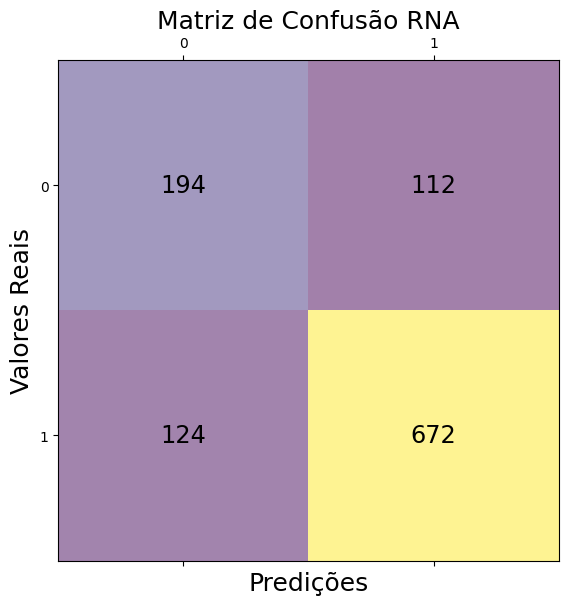

In [99]:
fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.matshow(cm, cmap='viridis', alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predições', fontsize=18)
plt.ylabel('Valores Reais', fontsize=18)
plt.title('Matriz de Confusão RNA', fontsize=18)
plt.show()


In [100]:
print(f'Previu {cm[1,1]} evadidos (1) corretamente')
print(f'Previu {cm[0,0]} concluintes (0) corretamente')
print(f'Previu incorretamente {cm[0,1]} concluintes quando eram evadidos')
print(f'Previu incorretamente {cm[1,0]} evadidos quando eram concluintes')

Previu 672 evadidos (1) corretamente
Previu 194 concluintes (0) corretamente
Previu incorretamente 112 concluintes quando eram evadidos
Previu incorretamente 124 evadidos quando eram concluintes


#### SVM x Logistic Regression x Rede neural

35/35 [==============================] - 0s 2ms/step


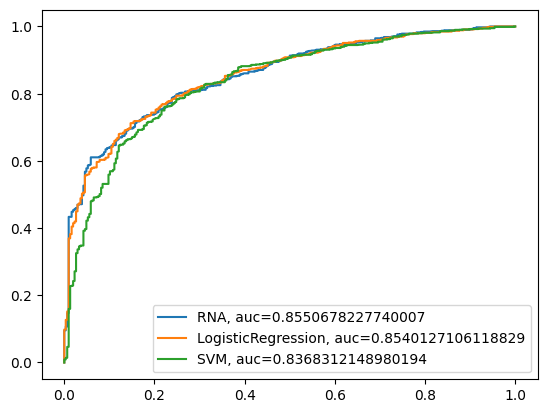

In [101]:
y_pred_probability = rna.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)
auc = metrics.roc_auc_score(y_test, y_pred_probability)
plt.plot(fpr,tpr,label="RNA, auc="+str(auc))

y_pred_probability = logistic_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)
auc = metrics.roc_auc_score(y_test, y_pred_probability)
plt.plot(fpr,tpr,label="LogisticRegression, auc="+str(auc))

y_pred_probability = clf_svm.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probability)
auc = metrics.roc_auc_score(y_test, y_pred_probability)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

plt.legend(loc=4)
plt.show()

## Conclusões

A regressão e logística e as redes neurais tiveram desempenhos quase iguais, então qualquer um dos modelos pode ser escolhido como o melhor.

Então nosso modelo final é o LogisticRegression.

#### Salvando o modelo

In [105]:
import pickle

with open ('logistic_model.pkl','wb') as f:
  pickle.dump([enc, sc, le, logistic_regression], f)